# This notebook develops and study controlled multiplcation modulo N
## Introduction
The function does (b+a*x)mod N operation, where b and x are quantum n-bits numbers, a and N are classical numbers with n-bits size
The algorithm is taken from arXiv:quant-ph/0205095
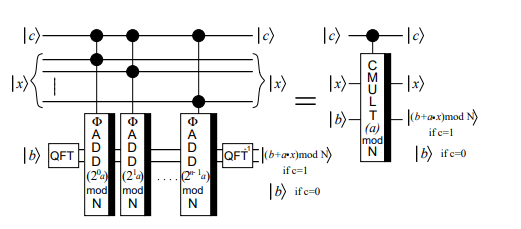

## Content
1) Development of the algorithm implementation
2) Testing the multiplier using a function from the quantum_routines library

## Description
1) The function has input of 2 * bit_size + 2 qubits. First qubit is the control one - qubit c. The next bit_size quibits are quantum number b. The nwxt bit_size qubits are qubtum number x. The last qubit is ancilla qubit used in calculations
2) There are 2 * bit_size classical registers. The first bit_size registers are for number a. The last registers are for number N
3) The output apears instead of the qubit set for quantum number b (not x)
   
## Important note 1
The highest bit in any number in te schematic above is the lowest bit in space. This is in contrast to my circuits below. The highest bit is the highest in space.

## Important note 2
Note tha while we multiply and add numbers with bit_size size, we use bit_size + 1 size numbers to do this. So, the highest bit of the resulting qubits does not matter. Only lower bit_size bits are meaningfull.

## Importnat note 3
The algorithm works only if b + a * x < 2 * N. This is because we subtract N only once


In [1]:
import qiskit
import numpy as np
import quantum_routines as qr
from qiskit import QuantumRegister as Q_R
from qiskit import ClassicalRegister as C_R

## Controlled multiplicator modulo N

C:\Users\Oleg\AppData\Local\Programs\Python\Python310\lib\site-packages\qiskit\circuit\quantumcircuit.py:3263: RuntimeWarning: Cregbundle set to False since an instruction needs to refer to individual classical wire
  return circuit_drawer(


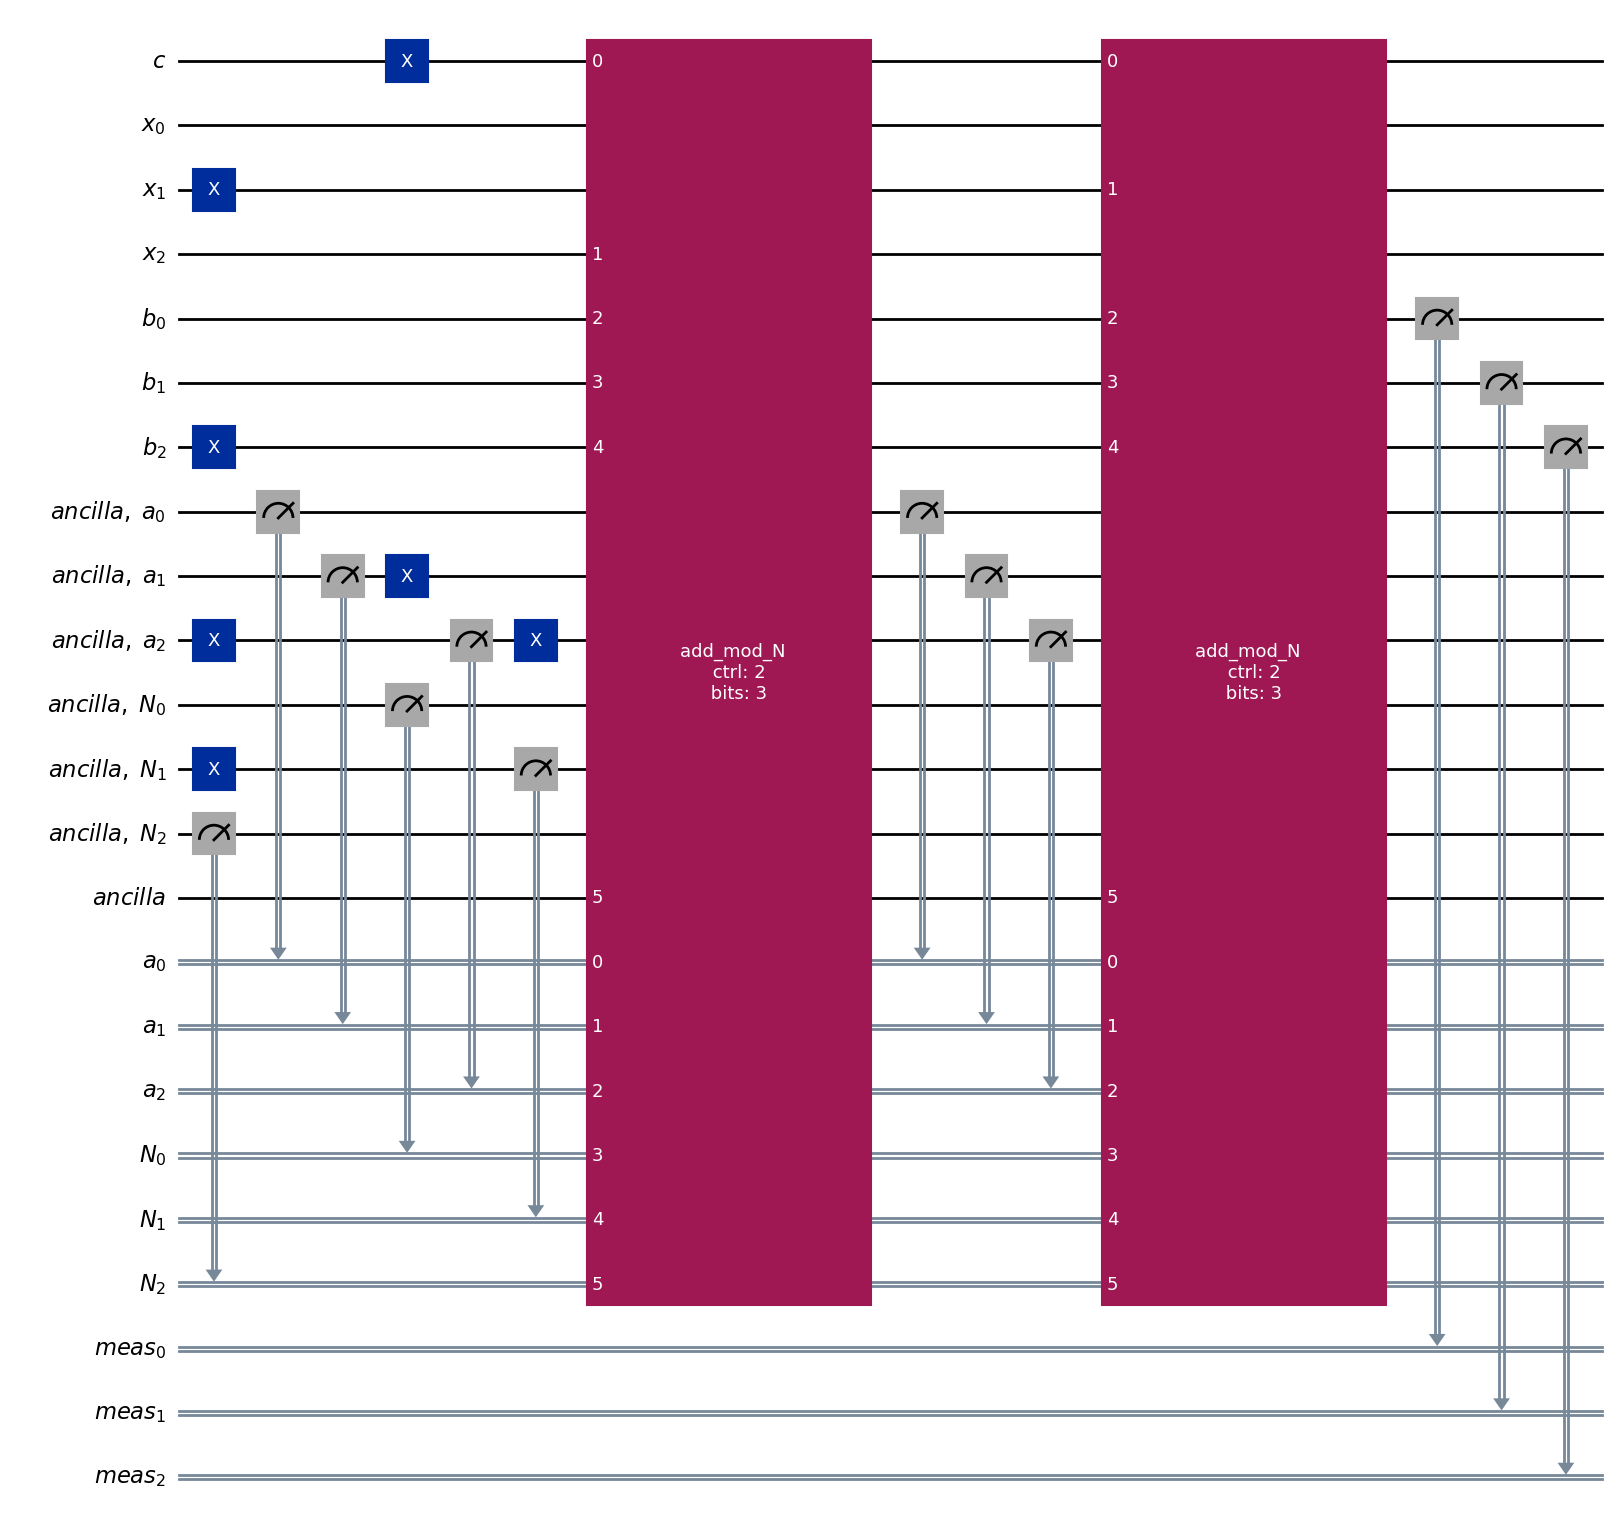

In [7]:
bit_size = 3

cl_num_a = [0, 1]
cl_num_N = [1, 0]
q_num_x = [1, 0]
q_num_b = [0, 1]
cl_control_bits = [1]

cl_num_a = [0] + cl_num_a
cl_num_N = [0] + cl_num_N
q_num_x = [0] + q_num_x
q_num_b = [0] + q_num_b

initial_a = []
initial_a[:] = cl_num_a[:]

q_reg_ctrl = Q_R(1, 'c') # control qubit
q_reg_x = Q_R(bit_size, 'x') # quantum number x
q_reg_b = Q_R(bit_size, 'b') # quantum number b

q_reg_a = Q_R(bit_size, 'ancilla, a') #ancilla qubits for classical number a
q_reg_N = Q_R(bit_size, 'ancilla, N') #ancilla qubits for classical number N

q_anc = Q_R(1, 'ancilla') # ancilla qubit

cl_reg_a = C_R(bit_size, 'a') #classical register for number a
cl_reg_N = C_R(bit_size, 'N') #classical register for number N
cl_reg_meas = C_R(bit_size, 'meas') #classical register for measured number

mult_mod_N = qiskit.QuantumCircuit(q_reg_ctrl, q_reg_x, q_reg_b, q_reg_a, q_reg_N, q_anc, cl_reg_a, cl_reg_N, cl_reg_meas)

#preparing quantum number x
mult_mod_N = qr.qubit_binary_prepare(q_reg_x, q_num_x, mult_mod_N)

#preparing quantum number b
mult_mod_N = qr.qubit_binary_prepare(q_reg_b, q_num_b, mult_mod_N)

#preparing classical number a 
mult_mod_N = qr.qubit_binary_prepare(q_reg_a, cl_num_a, mult_mod_N)
mult_mod_N = qr.qubits_meas(q_reg_a, cl_reg_a, mult_mod_N)

#preparing classical number N 
mult_mod_N = qr.qubit_binary_prepare(q_reg_N, cl_num_N, mult_mod_N)
mult_mod_N = qr.qubits_meas(q_reg_N, cl_reg_N, mult_mod_N)

#preparing control qubits
mult_mod_N = qr.qubit_binary_prepare(q_reg_ctrl, cl_control_bits, mult_mod_N)


for i in range(bit_size-1):
    inst = qr.ctrl_add_mod_N(bit_size, 2)
    qubits = [q_reg_ctrl]
    qubits.append(q_reg_x[bit_size -1 - i])
    for j in range(bit_size):
        qubits.append(q_reg_b[j])
    qubits.append(q_anc)
    cl_reg = [] 
    for j in range(bit_size):
        cl_reg.append(cl_reg_a[j])
    for j in range(bit_size):
        cl_reg.append(cl_reg_N[j])
    mult_mod_N.append(inst, qubits , cl_reg)
    if i < bit_size-2:
        #return the ancilla quibits for a number to the |0>^bit_size state
        mult_mod_N = qr.qubit_binary_prepare(q_reg_a, cl_num_a, mult_mod_N)
        #preparing classical number a * 2^i
        for j in range(bit_size-1):
            cl_num_a[j] = cl_num_a[j+1]
        cl_num_a[bit_size-1] = 0
        mult_mod_N = qr.qubit_binary_prepare(q_reg_a, cl_num_a, mult_mod_N)
        mult_mod_N = qr.qubits_meas(q_reg_a, cl_reg_a, mult_mod_N)

mult_mod_N = qr.qubits_meas(q_reg_b, cl_reg_meas, mult_mod_N)
mult_mod_N.draw('mpl')


We perfromed ([0, 0, 1] + [0, 0, 1] * [0, 1, 0]) mod[0, 1, 0].
The result is the lower third of bits in hystogram x-axis notation. The higher the bit is space the hisgher the bit digit.


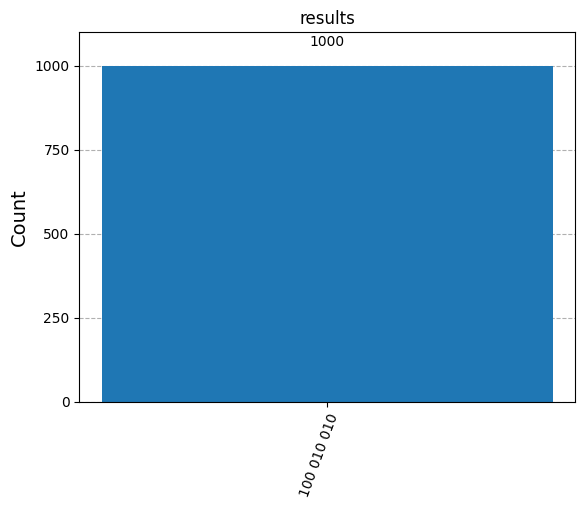

In [8]:
print('We perfromed (' + str(q_num_b) + ' + ' + str(initial_a) + ' * ' + str(q_num_x) + ') mod' + str(cl_num_N) + '.' )
print('The result is the lower third of bits in hystogram x-axis notation. The higher the bit is space the hisgher the bit digit.')
qr.plot_hyst_func(mult_mod_N,1000)

## Building (b + a * x) mod N multiplier using a function from quantum_routines library
The function does (b+a*x)mod N operation, where b and x are quantum bit_size-bits numbers, a and N are classical numbers with n-bits size 
    The algorithm is taken from arXiv:quant-ph/0205095 
    The function creates an instruction (single block) having 4 * (bit_size+1) + 2 qubits and 2 * (bit_size+1) classical bits as input and as output
    Each number (a, b, x and N) has bit_size+1 bits. So, the size of the numbers used in the calculations is 1 bit bigger than the size of numbers used by the user of this function
    The multiplier is controlled with one qubit
    The input should be in the order from first to last:
    the control qubit, 
    the quantum numbers x,
    the quentum number b,
    the ancilla qubits for classical number a
    the ancilla qubits for classical number N
    additional ancilla qubit
    the classical register for number a
    the classical register for number b

The function accepts clasical numbers a and N as parameters. Nevertheless they are converted into quantun bits inside the algorithm and then converted into a classical register.

Quantum numbers x and b are should come from previous stages of the bigger algorithm.

C:\Users\Oleg\AppData\Local\Programs\Python\Python310\lib\site-packages\qiskit\circuit\quantumcircuit.py:3263: RuntimeWarning: Cregbundle set to False since an instruction needs to refer to individual classical wire
  return circuit_drawer(


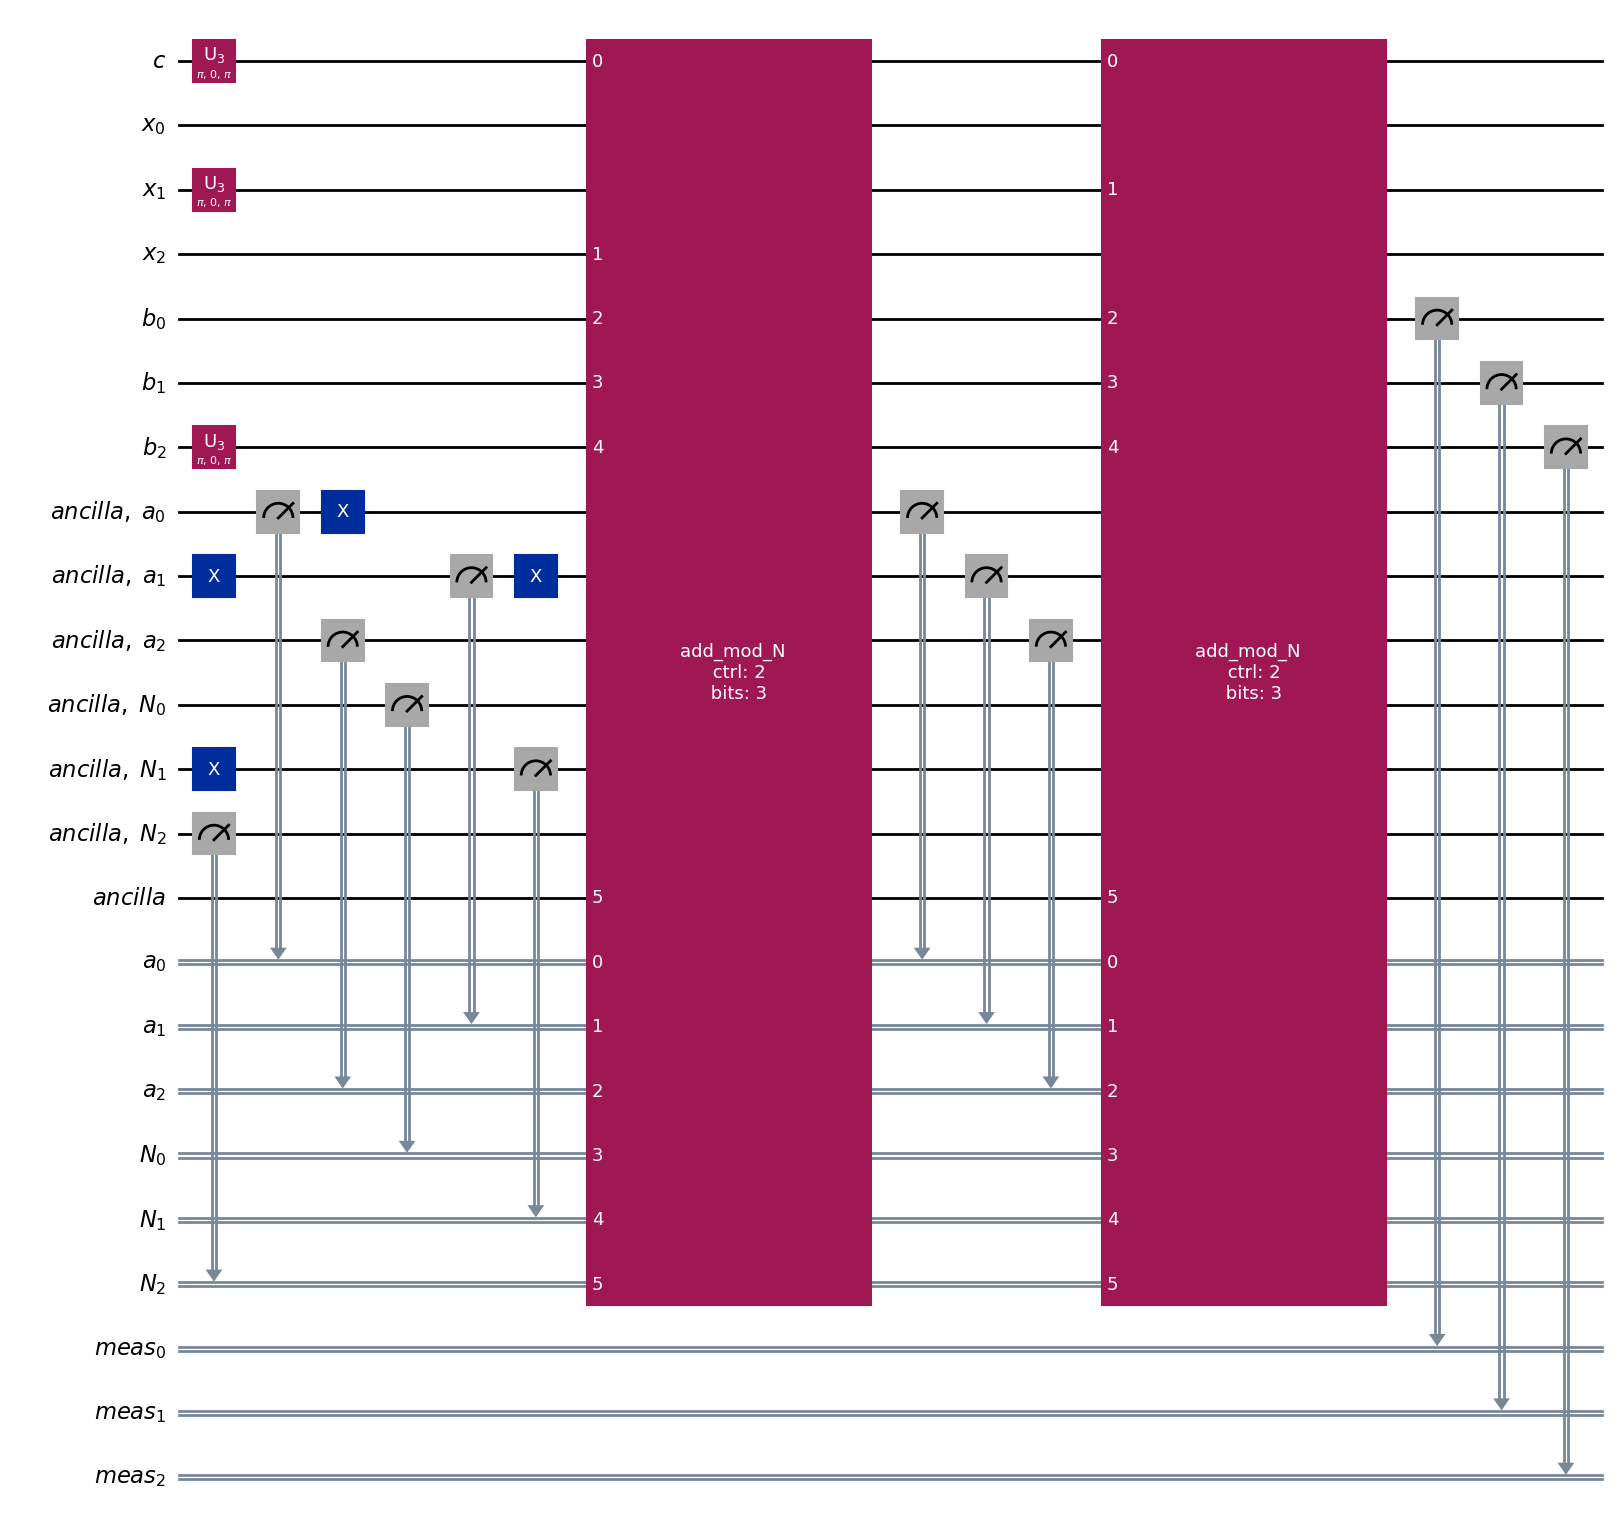

In [4]:
bit_size = 2

cl_num_a = [1, 0]
cl_num_N = [1, 0]
q_num_x =  [1, 0]
q_num_b =  [0, 1]

cl_control_bits = [1]

initial_a = []
initial_b = []
initial_x = []
initial_N = []

initial_a[:] = cl_num_a[:]
initial_b[:] = q_num_b[:]
initial_x[:] = q_num_x[:]
initial_N[:] = cl_num_N[:]

#cl_num_a = [0] + cl_num_a
#cl_num_N = [0] + cl_num_N
q_num_x = [0] + q_num_x
q_num_b = [0] + q_num_b



q_reg_ctrl = Q_R(1, 'c') # control qubit
q_reg_x = Q_R(bit_size + 1, 'x') # quantum number x
q_reg_b = Q_R(bit_size + 1, 'b') # quantum number b

q_reg_a = Q_R(bit_size + 1, 'ancilla, a') #ancilla qubits for classical number a
q_reg_N = Q_R(bit_size + 1, 'ancilla, N') #ancilla qubits for classical number N

q_anc = Q_R(1, 'ancilla') # ancilla qubit

cl_reg_a = C_R(bit_size + 1, 'a') #classical register for number a
cl_reg_N = C_R(bit_size + 1, 'N') #classical register for number N
cl_reg_meas = C_R(bit_size + 1, 'meas') #classical register for measured number

mult_mod_N = qiskit.QuantumCircuit(q_reg_ctrl, q_reg_x, q_reg_b, q_reg_a, q_reg_N, q_anc, cl_reg_a, cl_reg_N, cl_reg_meas)

#preparing quantum number x
mult_mod_N = qr.qubit_binary_prepare(q_reg_x, q_num_x, mult_mod_N)

#preparing quantum number b
mult_mod_N = qr.qubit_binary_prepare(q_reg_b, q_num_b, mult_mod_N)

#preparing control qubits
mult_mod_N = qr.qubit_binary_prepare(q_reg_ctrl, cl_control_bits, mult_mod_N)

instr = qr.ctrl_mult_mod_N(bit_size, cl_num_a, cl_num_N)
qubits = [q_reg_ctrl]
for i in range(bit_size + 1):
    qubits.append(q_reg_x[i])
for i in range(bit_size + 1):
    qubits.append(q_reg_b[i])
for i in range(bit_size + 1):
    qubits.append(q_reg_a[i])
for i in range(bit_size + 1):
    qubits.append(q_reg_N[i])
qubits.append(q_anc)

clbits = []
for i in range(bit_size + 1):
    clbits.append(cl_reg_a[i])
for i in range(bit_size + 1):
    clbits.append(cl_reg_N[i])

mult_mod_N.append(instr, qubits, clbits)

mult_mod_N = qr.qubits_meas(q_reg_b, cl_reg_meas, mult_mod_N)

mult_mod_N.decompose().draw('mpl')




We perfromed ([0, 1] + [1, 0] * [1, 0]) mod[1, 0].
The result is the lowest bit_size bits in the hystogram x-axis notation. The higher the bit is in space the hisgher the bit digit.


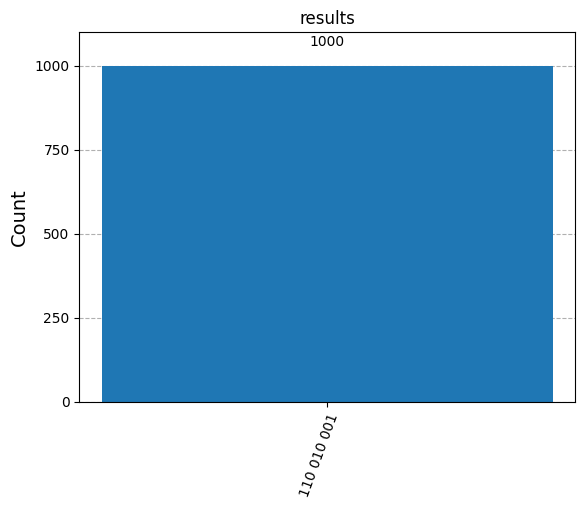

In [5]:
print('We perfromed (' + str(initial_b) + ' + ' + str(initial_a) + ' * ' + str(initial_x) + ') mod' + str(initial_N) + '.' )
print('The result is the lowest bit_size bits in the hystogram x-axis notation. The higher the bit is in space the hisgher the bit digit.')
qr.plot_hyst_func(mult_mod_N,1000)

## Building (b - a * x) mod N multiplier using a function from quantum_routines library
The function does (b - a * x)mod N operation, where b and x are quantum bit_size-bits numbers, a and N are classical numbers with n-bits size 
    The algorithm is taken from arXiv:quant-ph/0205095 
    The function creates an instruction (single block) having 4 * (bit_size + 1) + 2 qubits and 2 * (bit_size + 1) classical bits as input and as output
    Each number (a, b, x and N) has bit_size+1 bits. So, the size of the numbers used in the calculations is 1 bit bigger than the size of numbers used by the user of this function
    The multiplier is controlled with one qubit
    The input should be in the order from first to last:
    the control qubit, 
    the quantum numbers x,
    the quentum number b,
    the ancilla qubits for classical number a
    the ancilla qubits for classical number N
    additional ancilla qubit
    the classical register for number a
    the classical register for number b

The function accepts clasical numbers a and N as parameters. Nevertheless they are converted into quantun bits inside the algorithm and then converted into a classical register.

Quantum numbers x and b are should come from previous stages of the bigger algorithm.

### Important note
if b - a * x < 0, then mod N does nothing. In this case the result can be bigger than N, since b - a * x is replaced by b + 2^(n + 1)-a * x.

C:\Users\Oleg\AppData\Local\Programs\Python\Python310\lib\site-packages\qiskit\circuit\quantumcircuit.py:3263: RuntimeWarning: Cregbundle set to False since an instruction needs to refer to individual classical wire
  return circuit_drawer(


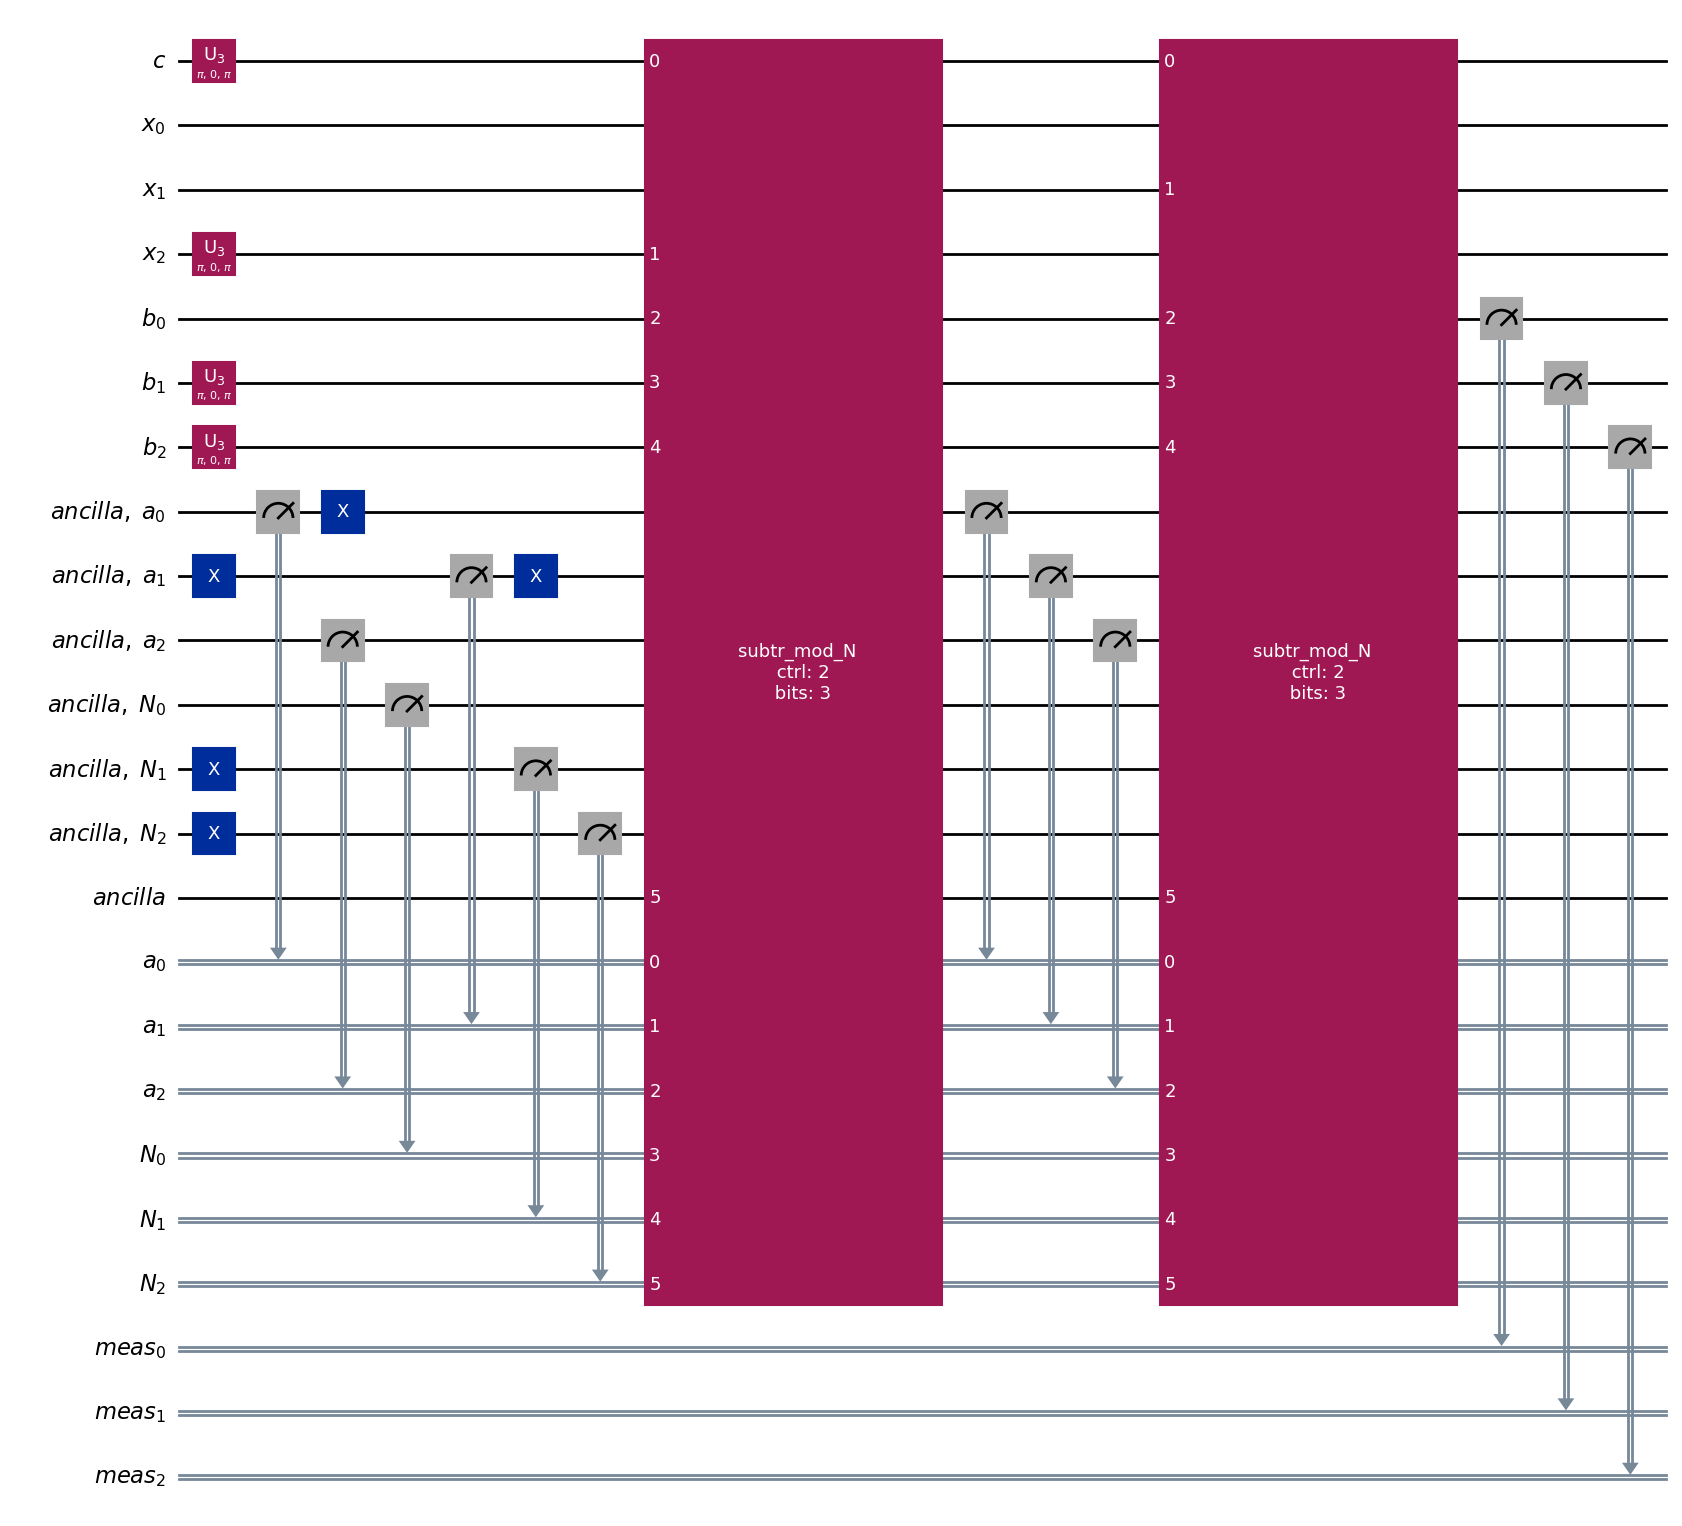

In [5]:
import qiskit
import numpy as np
import quantum_routines as qr
from qiskit import QuantumRegister as Q_R
from qiskit import ClassicalRegister as C_R

bit_size = 2

cl_num_a = [1, 0]
cl_num_N = [1, 1]
q_num_x =  [0, 1]
q_num_b =  [1, 1]

cl_control_bits = [1]

initial_a = []
initial_b = []
initial_x = []
initial_N = []

initial_a[:] = cl_num_a[:]
initial_b[:] = q_num_b[:]
initial_x[:] = q_num_x[:]
initial_N[:] = cl_num_N[:]

#cl_num_a = [0] + cl_num_a
#cl_num_N = [0] + cl_num_N
q_num_x = [0] + q_num_x
q_num_b = [0] + q_num_b



q_reg_ctrl = Q_R(1, 'c') # control qubit
q_reg_x = Q_R(bit_size + 1, 'x') # quantum number x
q_reg_b = Q_R(bit_size + 1, 'b') # quantum number b

q_reg_a = Q_R(bit_size + 1, 'ancilla, a') #ancilla qubits for classical number a
q_reg_N = Q_R(bit_size + 1, 'ancilla, N') #ancilla qubits for classical number N

q_anc = Q_R(1, 'ancilla') # ancilla qubit

cl_reg_a = C_R(bit_size + 1, 'a') #classical register for number a
cl_reg_N = C_R(bit_size + 1, 'N') #classical register for number N
cl_reg_meas = C_R(bit_size + 1, 'meas') #classical register for measured number

mult_mod_N = qiskit.QuantumCircuit(q_reg_ctrl, q_reg_x, q_reg_b, q_reg_a, q_reg_N, q_anc, cl_reg_a, cl_reg_N, cl_reg_meas)

#preparing quantum number x
mult_mod_N = qr.qubit_binary_prepare(q_reg_x, q_num_x, mult_mod_N)

#preparing quantum number b
mult_mod_N = qr.qubit_binary_prepare(q_reg_b, q_num_b, mult_mod_N)

#preparing control qubits
mult_mod_N = qr.qubit_binary_prepare(q_reg_ctrl, cl_control_bits, mult_mod_N)

instr = qr.ctrl_mult_mod_N_s(bit_size, cl_num_a, cl_num_N)
qubits = [q_reg_ctrl]
for i in range(bit_size + 1):
    qubits.append(q_reg_x[i])
for i in range(bit_size + 1):
    qubits.append(q_reg_b[i])
for i in range(bit_size + 1):
    qubits.append(q_reg_a[i])
for i in range(bit_size + 1):
    qubits.append(q_reg_N[i])
qubits.append(q_anc)

clbits = []
for i in range(bit_size + 1):
    clbits.append(cl_reg_a[i])
for i in range(bit_size + 1):
    clbits.append(cl_reg_N[i])

mult_mod_N.append(instr, qubits, clbits)

mult_mod_N = qr.qubits_meas(q_reg_b, cl_reg_meas, mult_mod_N)

mult_mod_N.decompose().draw('mpl')

We perfromed ([1, 1] - [1, 0] * [0, 1]) mod[1, 1].
The result is the lowest bit_size bits in the hystogram x-axis notation. The higher the bit is in space the hisgher the bit digit.


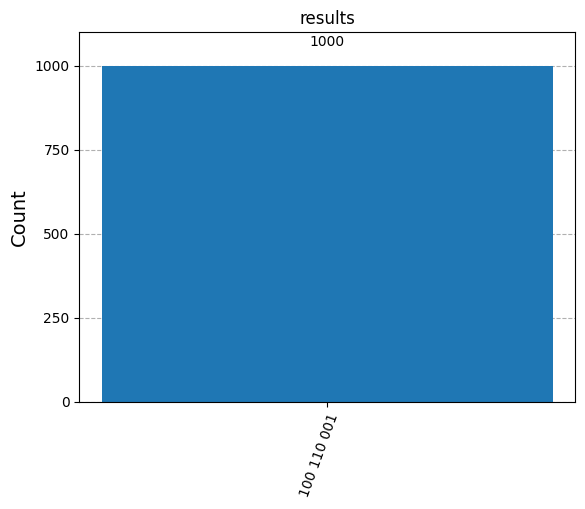

In [6]:
print('We perfromed (' + str(initial_b) + ' - ' + str(initial_a) + ' * ' + str(initial_x) + ') mod' + str(initial_N) + '.' )
print('The result is the lowest bit_size bits in the hystogram x-axis notation. The higher the bit is in space the hisgher the bit digit.')
qr.plot_hyst_func(mult_mod_N, 1000)